In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import rioxarray as rioxr
# import xarray as xr

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import rasterio
import geopandas as gpd

import pystac_client 
import planetary_computer as pc

# from shapely.geometry import Polygon

#import iceplant_detection_functions as ipf

In [4]:
fp = os.path.join(os.getcwd(),'campus_lagoon_2018_lidar.csv')
df = pd.read_csv(fp)
df.head(3)

,Unnamed: 0,iceplant,r,g,b,nir,year,month,day,naip_id,polygon_id,geometry,lidar,max_lidar_w,min_lidar_w,min_max_diff,avg_lidar_w
0,0,1,93,88,93,141,2018,7,22,ca_m_3411934_sw_11_060_20180722_20190209,0,POINT (238343.42981319653 3810848.805207873),4,5,2,3,3.333333
1,1,1,85,85,89,137,2018,7,22,ca_m_3411934_sw_11_060_20180722_20190209,0,POINT (238343.54673072172 3810846.093093588),4,5,2,3,3.333333
2,2,1,89,85,91,133,2018,7,22,ca_m_3411934_sw_11_060_20180722_20190209,0,POINT (238344.86438268572 3810845.534717399),4,5,2,3,3.333333


In [6]:
df.drop(['Unnamed: 0','month','day','year','naip_id','polygon_id'], axis=1,inplace=True)
df.head(3)

,iceplant,r,g,b,nir,geometry,lidar,max_lidar_w,min_lidar_w,min_max_diff,avg_lidar_w
0,1,93,88,93,141,POINT (238343.42981319653 3810848.805207873),4,5,2,3,3.333333
1,1,85,85,89,137,POINT (238343.54673072172 3810846.093093588),4,5,2,3,3.333333
2,1,89,85,91,133,POINT (238344.86438268572 3810845.534717399),4,5,2,3,3.333333


In [7]:
df['ndvi']=(df.nir.astype('int16') - df.r.astype('int16'))/(df.nir.astype('int16') + df.r.astype('int16'))
df.head(3)

,iceplant,r,g,b,nir,geometry,lidar,max_lidar_w,min_lidar_w,min_max_diff,avg_lidar_w,ndvi
0,1,93,88,93,141,POINT (238343.42981319653 3810848.805207873),4,5,2,3,3.333333,0.205128
1,1,85,85,89,137,POINT (238343.54673072172 3810846.093093588),4,5,2,3,3.333333,0.234234
2,1,89,85,91,133,POINT (238344.86438268572 3810845.534717399),4,5,2,3,3.333333,0.198198


In [9]:
df = df[['r','g','b','nir','ndvi',
         'lidar','max_lidar_w', 'min_lidar_w', 'min_max_diff', 'avg_lidar_w',
         'iceplant']]
df.head(3)

,r,g,b,nir,ndvi,lidar,max_lidar_w,min_lidar_w,min_max_diff,avg_lidar_w,iceplant
0,93,88,93,141,0.205128,4,5,2,3,3.333333,1
1,85,85,89,137,0.234234,4,5,2,3,3.333333,1
2,89,85,91,133,0.198198,4,5,2,3,3.333333,1


In [10]:
y = np.array(df['iceplant'])
X= np.array(df.drop('iceplant', axis = 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import fbeta_score

def iceplant_proportions(labels):
    unique, counts = np.unique(labels, return_counts=True)
    print('no-iceplant:iceplant ratio    ',round(counts[0]/counts[1],1),':1')
    n = labels.shape[0]
    perc = [round(counts[0]/n*100,2), round(counts[1]/n*100,2)]
    df = pd.DataFrame({'iceplant':unique,
             'counts':counts,
             'percentage':perc}).set_index('iceplant')
    print(df)
    print()

def test_train_proportions(train_labels, test_labels):
    print('TRAIN SET COUNTS:')
    iceplant_proportions(train_labels)

    print('TEST SET COUNTS:')
    iceplant_proportions(test_labels)

    return

def print_accuracy_info(y_true,y_pred):
    N = y_true.shape[0]
    
    confmtx = confusion_matrix(y_true,y_pred)
    
    print('true negatives:', confmtx[0,0], 
          '    false positives:', confmtx[0,1])
    print('false negatives:', confmtx[1,0], 
          '    true positives:', confmtx[1,1])
    print()
    unique, counts = np.unique(y_true,return_counts=True)
    
    sens =  confmtx[1,1]/counts[1]
    spec =  confmtx[0,0]/counts[0]
    print('sensitivity (TP/P):', np.round(sens*100,2), '%')  
    print('specificity (TN/N):', np.round(spec*100,2), '%')  
    print('G-mean: ', round(np.sqrt(sens*spec),2))
    print()
    
    prec = confmtx[1,1]/(confmtx[1,1]+confmtx[0,1])
    print('precision (TP/(TP+FP)):', np.round(prec*100,2),'%' )
    print()
    
    print('MCC: ', matthews_corrcoef(y_true,y_pred))
    print()
    
    print('F1-measure: ',  round(fbeta_score(y_true, y_pred, beta=1.0),5))
    print('F0.5-measure (min false positives): ',  round(fbeta_score(y_true, y_pred, beta=0.5),5))
    print('F2-measure (min false negatives)  : ',  round(fbeta_score(y_true, y_pred, beta=2.0),5))
    print()
        
    print('accuracy:', np.round( (confmtx[1,1] + confmtx[0,0])/y_true.shape[0]*100,2),'%') # (TP + TN)/(P + N)
    return

In [14]:
test_train_proportions(y_train, y_test)

TRAIN SET COUNTS:
no-iceplant:iceplant ratio     9.7 :1
          counts  percentage
iceplant                    
0          44017       90.62
1           4556        9.38

TEST SET COUNTS:
no-iceplant:iceplant ratio     10.0 :1
          counts  percentage
iceplant                    
0          18925       90.91
1           1893        9.09



In [15]:
rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [20]:
predictions = rfc.predict(X_test)
print_accuracy_info(y_test, predictions)

true negatives: 18914     false positives: 11
false negatives: 22     true positives: 1871

sensitivity (TP/P): 98.84 %
specificity (TN/N): 99.94 %
G-mean:  0.99

precision (TP/(TP+FP)): 99.42 %

MCC:  0.9903917618798886

F1-measure:  0.99126
F0.5-measure (min false positives):  0.99299
F2-measure (min false negatives)  :  0.98953

accuracy: 99.84 %


In [21]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rfc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

In [22]:
forest_importances = pd.Series(result.importances_mean, 
                               index=['r','g','b','nir','ndvi',
                                       'lidar','max_lidar_w', 'min_lidar_w', 'min_max_diff', 'avg_lidar_w'])
forest_importances

r               0.047930
g               0.033778
b               0.015487
nir             0.031180
ndvi            0.005716
lidar           0.002935
max_lidar_w     0.014545
min_lidar_w     0.002392
min_max_diff    0.030209
avg_lidar_w     0.007666
dtype: float64

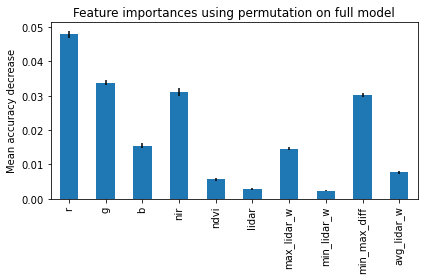

In [23]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

## Trying only with spectral features

In [28]:
df_spectral = df.drop(['lidar','max_lidar_w', 'min_lidar_w', 'min_max_diff', 'avg_lidar_w'],axis=1)
y = np.array(df_spectral['iceplant'])
X= np.array(df_spectral.drop('iceplant', axis = 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [29]:
rfc_spectral = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc_spectral.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [30]:
predictions = rfc_spectral.predict(X_test)
print_accuracy_info(y_test, predictions)

true negatives: 18803     false positives: 122
false negatives: 98     true positives: 1795

sensitivity (TP/P): 94.82 %
specificity (TN/N): 99.36 %
G-mean:  0.97

precision (TP/(TP+FP)): 93.64 %

MCC:  0.9364638774316778

F1-measure:  0.94226
F0.5-measure (min false positives):  0.93871
F2-measure (min false negatives)  :  0.94583

accuracy: 98.94 %


## Applying model with lidar to NAIP campus lagoon aoi

In [34]:
aois = gpd.read_file('/home/jovyan/msai4earth-esa/iceplant_detection/areas_of_interest/areas_of_interest.shp')
cl = aois.iloc[4]  # Campus Lagoon aoi
cl

name                                              campus point
region                                                  goleta
itemid_12               ca_m_3411934_sw_11_1_20120505_20120730
itemid_14               ca_m_3411934_sw_11_1_20140601_20141030
itemid_16              ca_m_3411934_sw_11_.6_20160713_20161004
itemid_18             ca_m_3411934_sw_11_060_20180722_20190209
itemid_20                      ca_m_3411934_sw_11_060_20200521
geometry     POLYGON ((-119.8534713523 34.4028697719, -119....
Name: 4, dtype: object

In [35]:
#obtain href to NAIP scene
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = pystac_client.Client.open(URL)

search = catalog.search(
        collections=["naip"],
        ids = cl.itemid_18        
    )

item = list(search.get_items())[0]
href = pc.sign(item.assets["image"].href)

In [36]:
# clip NAIP scene to aoi
reduce = aois.iloc[[4]] # retrieve row as gpd GeoDataFrame

ds = rasterio.open(href)

#reduce = gpd.GeoDataFrame({'geometry':[reduce_box]}, crs="EPSG:4326")
reduce = reduce.to_crs(ds.crs)

In [37]:
import rioxarray as rioxr
import xarray as xr

In [38]:
# rioxarray of complete naip scene (two ways of getting it, second probably better?)
naip_scene = rioxr.open_rasterio(rasterio.open(href))
#naip_scene = xr.open_dataset(href, engine='rasterio')
#naip_scene

# mask naip scene with Campus Point bounding box
naip_clip = naip_scene.rio.clip_box(*reduce.total_bounds)
naip_clip

<xarray.DataArray (band: 4, y: 1925, x: 1969)>
[15161300 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 2.377e+05 2.377e+05 ... 2.389e+05 2.389e+05
  * y            (y) float64 3.812e+06 3.812e+06 3.812e+06 ... 3.81e+06 3.81e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [39]:
fp = os.path.join(os.getcwd(),'3mlidar_over_campuspoint_naip_scene.tif')
lidar = rioxr.open_rasterio(fp)

In [39]:
# resample using the naip_subset
lidar_match = lidar.rio.reproject_match(naip_clip)
lidar_match = lidar_match.squeeze()
lidar_match

<xarray.DataArray (y: 1925, x: 1969)>
array([[    3,     3,     3, ...,     1,     1,     1],
       [    3,     3,     3, ...,     1,     1,     1],
       [    3,     3,     3, ...,     1,     1,     1],
       ...,
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999]], dtype=int16)
Coordinates:
  * x            (x) float64 2.377e+05 2.377e+05 ... 2.389e+05 2.389e+05
  * y            (y) float64 3.812e+06 3.812e+06 3.812e+06 ... 3.81e+06 3.81e+06
    band         int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    _FillValue:    -9999

In [ ]:
image = naip_clip.to_numpy()    # extract np array
veg = ipf.select_ndvi_df(image) # extract pixels with vegetation as df